In [ ]:
!pip install gym[box2d]

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
from collections import deque
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
import matplotlib.pyplot as plt
import os
import gym
import random



# In[2]:


class ReplayMemory():
   

    def __init__(self, batch_size):
        self.max_mem = 1000000

        self.experiences = deque(maxlen=self.max_mem)
        self.batch_size = batch_size

    def Memory(self, state, action, reward, next_state,done): 
        
        """
        Store Experiences.
        
        """

        self.experiences.append((state, action, reward, next_state,done))
        

    def Replay(self):
    
        """
        Random Sample bacthes from the stored experiences.
        
        """
     
        batch_size = min(self.batch_size, len(self.experiences))
        samples = random.sample(self.experiences, batch_size)
        
        states, actions, rewards,next_states,dones =  map(list,zip(*samples))
        
        states = tf.convert_to_tensor(np.array(states), dtype = tf.float32)
        actions = tf.convert_to_tensor(np.array(actions), dtype = tf.float32)
        rewards = tf.convert_to_tensor(np.array(rewards), dtype = tf.float32)
        next_states = tf.convert_to_tensor(np.array(next_states), dtype = tf.float32)
        dones = tf.convert_to_tensor(np.array(dones), dtype = tf.float32)
        
    
        return states, actions, rewards,next_states,dones


# In[3]:


class Actor(keras.Model):
    
    # 2 Actor Networks: One Actor and One Target:
    
    def __init__(self, layer1, layer2, output_actions):
        super(Actor, self).__init__()
        
        self.layer1 = layer1
        self.layer2 = layer2
        self.output_actions =output_actions
        self.Dense1 = keras.layers.Dense(self.layer1, activation = 'relu')
        self.Dense2 = keras.layers.Dense(self.layer2, activation = 'relu')
        self.out_a = keras.layers.Dense(self.output_actions, activation = 'tanh')
     
        
 
    def call(self, state):
        act = self.Dense1(state)
        act = self.Dense2(act)
        out_act = self.out_a(act)

        return out_act
    


# In[4]:


class Critic(keras.Model):
    def __init__(self,layer1, layer2, output_actions):
        super(Critic, self).__init__()
        
        self.layer1 = layer1
        self.layer2 = layer2
        self.output_actions = output_actions
        self.Dense1 = keras.layers.Dense(self.layer1, activation = 'relu')
        self.Dense2 = keras.layers.Dense(self.layer2, activation = 'relu')
        self.out_c1 = keras.layers.Dense(1, activation=None)
        
        self.Dense3 = keras.layers.Dense(self.layer1, activation = 'relu')
        self.Dense4 = keras.layers.Dense(self.layer2, activation = 'relu')
        self.out_c2 = keras.layers.Dense(1, activation=None)
        
  
    def call(self, state, action):
    
    
        crit1 = self.Dense1(tf.concat([state, action], axis=1))
        crit1 = self.Dense2(crit1)
        out_crit1 = self.out_c1(crit1)
        
        crit2 = self.Dense3(tf.concat([state, action], axis=1))
        crit2 = self.Dense4(crit2)
        out_crit2 = self.out_c2(crit2)

        return out_crit1, out_crit2
    
    


# In[10]:


class Agent():
    def __init__(self, lr, input_dims, tau, env,layer1, layer2, batch_size,
            gamma,noise,output_actions, plays=1000
            ,max_size=1000000):
      
        self.gamma = gamma
        self.tau = tau
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]
        self.update = 2
        self.batch_size = batch_size
        self.memory = ReplayMemory(self.batch_size)
        self.noise = noise
        self.step = 0
        self.time_step = 0
        self.plays= plays
        self.output_actions = output_actions
        

        self.actor = Actor(layer1, layer2,output_actions)
        self.actor_target = Actor(layer1, layer2, output_actions)
        self.actor.compile(optimizer=Adam(learning_rate=lr), loss='mean')
        self.actor_target.compile(optimizer=Adam(learning_rate=lr), loss='mean')
        
        
        self.critic = Critic(layer1, layer2, output_actions)
        self.critic_target = Critic(layer1, layer2, output_actions)
        self.critic.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        self.critic_target.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
                              

        
    def gaussian_noise(self, noise, size):
        
        return np.random.normal(scale = noise, size = size)

    def decide_action(self, state):
        
        if self.time_step > self.plays:
            
            state = tf.convert_to_tensor([state], dtype=tf.float32)
            pi = self.actor(state)[0] # returns a batch size of 1, want a scalar array
            
            
        else:
            pi = self.gaussian_noise(self.noise, size=(self.output_actions,))
            
        pi_prime = pi + self.gaussian_noise(self.noise, size = None)

        pi_prime = tf.clip_by_value(pi_prime, self.min_action, self.max_action)
        self.time_step += 1

        return pi_prime

    def store_experiences(self, state, action, reward, new_state, done):
        self.memory.Memory(state, action, reward, new_state, done)

    def train(self):
        if len(self.memory.experiences) > self.batch_size:
            

            states, actions, rewards, next_states, dones = self.memory.Replay()



            with tf.GradientTape(persistent=True) as tape:
                actions_target = self.actor_target(next_states)
                actions_target = actions_target + tf.clip_by_value(self.gaussian_noise(0.2, size = None), -0.5,0.5)
                actions_target = tf.clip_by_value(actions_target, self.min_action, self.max_action)


                Q1, Q2 = self.critic(states, actions)
                Q1_target, Q2_target = self.critic_target(next_states, actions_target)

                Q1, Q2 = tf.squeeze(Q1, axis = 1), tf.squeeze(Q2, axis = 1)
                Q1_target, Q2_target = tf.squeeze(Q1_target, 1), tf.squeeze(Q2_target, 1)

           
             
                critic_value = tf.minimum(Q1_target, Q2_target)
                target = rewards + self.gamma*critic_value*(1-dones)

                critic_loss =  MSE(target, Q1) + MSE(target, Q2)

            Q_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
           
            self.critic.optimizer.apply_gradients(zip(Q_grad, self.critic.trainable_variables))


            self.step += 1


            if self.step% self.update == 0:


                with tf.GradientTape() as tape:
                    next_actions = self.actor(states)
                    Q1_value, Q2_value = self.critic(states, next_actions)
                    loss_actor = -tf.reduce_mean(Q1_value)

                actor_grad = tape.gradient(loss_actor, self.actor.trainable_variables)
                self.actor.optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))
                    
                
                self.update_weights(self.actor, self.actor_target)
                self.update_weights(self.critic, self.critic_target)
            
            
            
    def polyack_average(self,weigh, target):
         
        p_avg = weigh *self.tau+ target*(1-self.tau)
        return p_avg
    
    def get_new_weights(self, network, network_target):
        
        new_weights = []
        targets = network_target.weights
        weights = network.weights
       
       
        for i in range(len(weights)):
        
            new_weights.append(self.polyack_average(weights[i],targets[i]))
    
        return new_weights

    def update_weights(self, network, network_target):

        new_weights = self.get_new_weights(network, network_target)
        network_target.set_weights(new_weights)
        
    def save_models(self):
        
        file = 'model'
        self.actor.save_weights(os.path.join(file,'actor'))
        self.critic.save_weights(os.path.join(file,'critic'))
        self.actor_target.save_weights(os.path.join(file,'actor_target'))
        self.critic_target.save_weights(os.path.join(file,'critic_target'))
       
        
    def load_models(self):
        
        file = 'model'
        self.actor.load_weights(os.path.join(file,'actor'))
        self.critic.load_weights(os.path.join(file,'critic'))
        self.actor_target.load_weights(os.path.join(file,'actor_target'))
        self.critic_target.load_weights(os.path.join(file,'critic_target'))

# In[7]:

import pandas as pd


def save_data(history):
    
    df = pd.DataFrame(history, columns=["Average Reward"])
    df.to_csv('params/list.csv', index=False)


# In[8]:


def plot_avg_reward(episodes, average_reward):
    eps = np.arange(0, episodes, 1)
    plt.plot(eps, average_reward)
    plt.title('Average Reward over 1000 episodes')
    plt.savefig('avg_reward.png')


# In[10]:


def video():
    pass


# In[ ]:


if __name__ == '__main__':
    
    env = gym.make('Pendulum-v1')
  
   
    agent = Agent(lr=0.001, input_dims=env.observation_space.shape, tau=0.005, env=env,
                  batch_size=100, layer1=400, layer2=300,output_actions =env.action_space.shape[0],
                 gamma = 0.99, noise = 0.1)
    
    Episodes = 1000
    max_score = 190
    history = []
    avg_reward_list = []

    for episode in range(Episodes):
        state = env.reset()
        done = False
        score = 0
        while not done:
            action = agent.decide_action(state)
            state_, reward, done, info = env.step(action)
            agent.store_experiences(state, action, reward, state_, done)
            agent.train()
            score += reward
            state = state_
    
        history.append(score)
        avg_reward = np.mean(history[-100:])
        avg_reward_list.append(avg_reward)
        
        
        if avg_reward > max_score:
            max_score = avg_reward
            agent.save_models()

        print('Episode: ', episode, ', Average reward: ', avg_reward)
        
    env.close()
    save_data(avg_reward_list)
    plot_avg_reward(Episodes, avg_reward_list)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode:  0 , Average reward:  -1911.7957054710366
Episode:  1 , Average reward:  -1591.4623088231806
Episode:  2 , Average reward:  -1558.912284109014
Episode:  3 , Average reward:  -1389.4221281367288
Episode:  4 , Average reward:  -1314.843247483647
Episode:  5 , Average reward:  -1316.8458426795012
Episode:  6 , Average reward:  -1314.903461666337
Episode:  7 , Average reward:  -1297.78569039777
Episode:  8 , Average reward:  -1311.5175653842534
Episode:  9 , Average reward:  -1312.9632922418516
Episode:  10 , Average reward:  -1304.3409657464913
Episode:  11 , Average reward:  -1337.192128595964
Episode:  12 , Average reward:  -1334.1098315430418
Episode:  13 , Average reward:  -1320.1126201772438
Episode:  14 , Average reward:  -1338.3112804941702
Episode:  15 , Average reward:  -1336.269605429166
Episode:  16 , Average reward:  -1355.9757178712437
Episode:  17 , Average reward:  -1359.4527434062793
Episode:  18 , Average reward:  -1348.1169279370554
Episode:  19 , Average reward

NameError: ignored

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


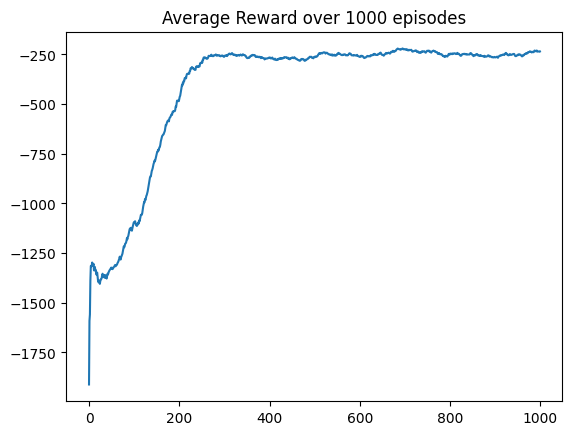

In [3]:
plot_avg_reward(Episodes, avg_reward_list)